# 1. Pre-Process The Data

## 1.1. Data Pre-Processing

In [4]:
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already present
stop_words = set(stopwords.words('english'))

def load_annotations(annotation_file):
    """Load and process the annotation file."""
    data = []
    with open(annotation_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                file_name, narrative, sub_narrative = parts
                narratives = narrative.split(';')  # Split multiple narratives
                sub_narratives = sub_narrative.split(';')  # Split multiple sub-narratives
                
                # Handle 'Other' category
                if 'Other' in narratives and len(narratives) == 1:
                    narratives = ['Other']
                    sub_narratives = ['Other']
                
                data.append([file_name, narratives, sub_narratives])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=["File Name", "Narrative Labels", "Sub-Narrative Labels"])
    return df

def preprocess_text(text):
    """Clean and tokenize text while removing stopwords."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

def load_text_data(text_folder):
    """Read and preprocess text from files."""
    text_data = []
    for file_name in os.listdir(text_folder):
        file_path = os.path.join(text_folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            cleaned_text = preprocess_text(content)
            text_data.append([file_name, cleaned_text])
    
    df_texts = pd.DataFrame(text_data, columns=["File Name", "Text Content"])
    return df_texts

def save_to_json(df, output_file):
    """Save DataFrame to a JSON file."""
    df.to_json(output_file, orient='records', indent=4, force_ascii=False)


# Example usage
annotation_file = "narrative_classification/training_data/eng/subtask_2_annotations.txt"  # Update with actual file path
text_folder = "narrative_classification/training_data/eng/raw_documents"  # Update with actual folder path
output_json_file = "processed_data.json"  # Output JSON file

df_annotations = load_annotations(annotation_file)
df_texts = load_text_data(text_folder)

# Merge data
df_merged = df_annotations.merge(df_texts, on="File Name", how="left")

# Save to JSON
save_to_json(df_merged, output_json_file)

# Display DataFrame
print(df_merged.head())

          File Name                     Narrative Labels  \
0  EN_CC_100013.txt  [CC: Criticism of climate movement]   
1  EN_UA_300009.txt                              [Other]   
2  EN_UA_300017.txt                              [Other]   
3  EN_CC_100021.txt                              [Other]   
4  EN_UA_300041.txt                              [Other]   

                                Sub-Narrative Labels  \
0  [CC: Criticism of climate movement: Ad hominem...   
1                                            [Other]   
2                                            [Other]   
3                                            [Other]   
4                                            [Other]   

                                        Text Content  
0  bill gates says solution climate change ok fou...  
1  russia clashes erupt bashkortostan rights acti...  
2  mcdonalds exit russia sell business country am...  
3  collaborative plans innovation keys circular r...  
4  russia intends supply li

## 1.2. Exploratory Data Analysis

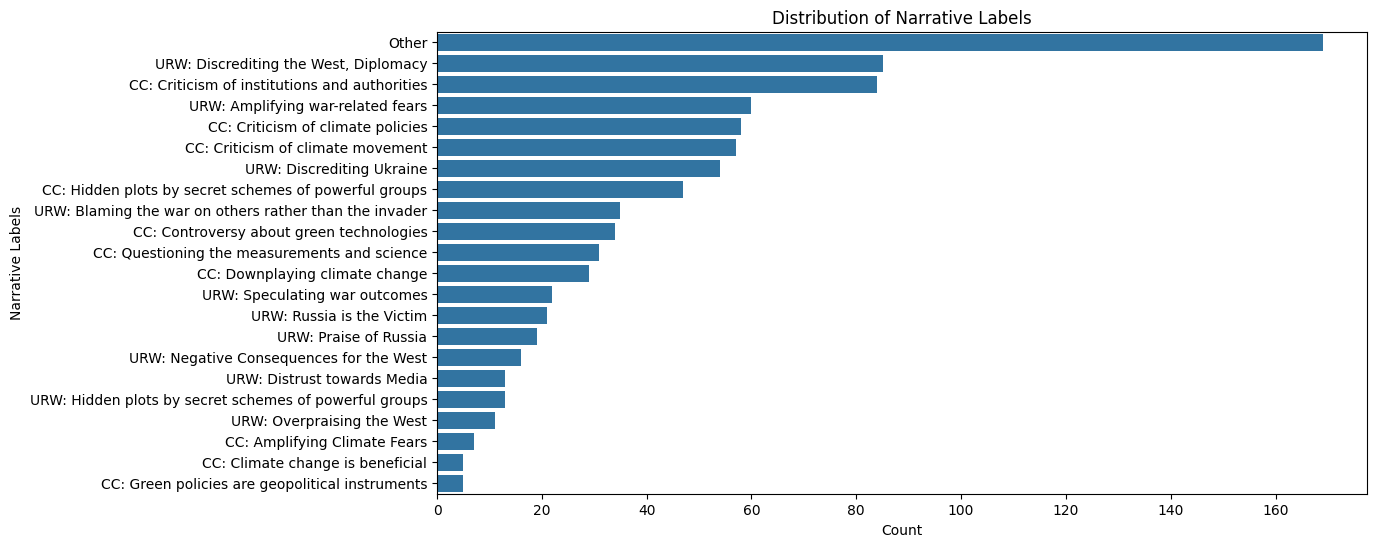

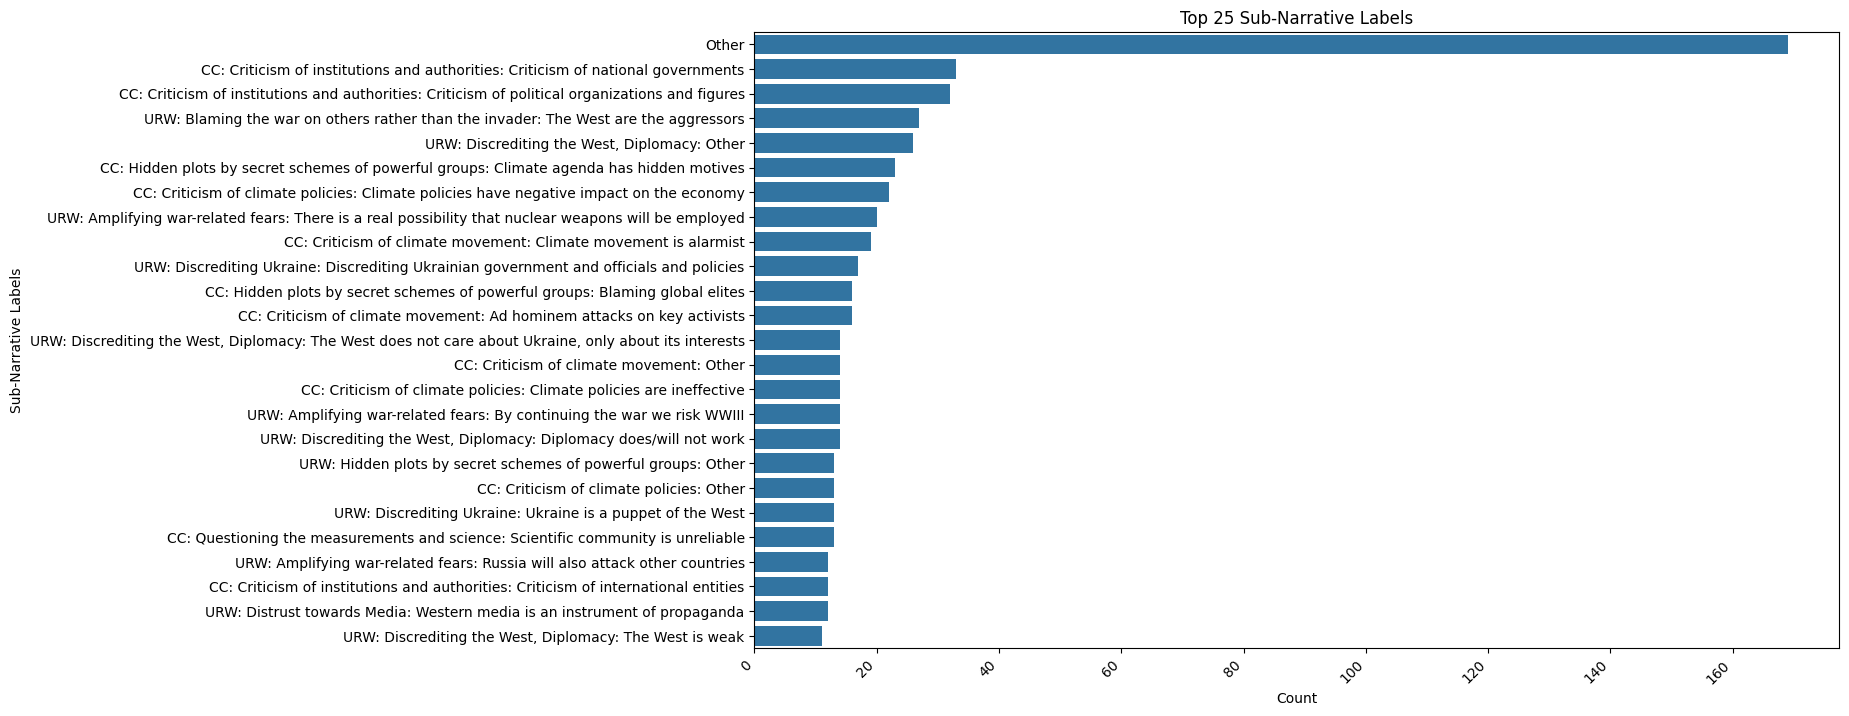

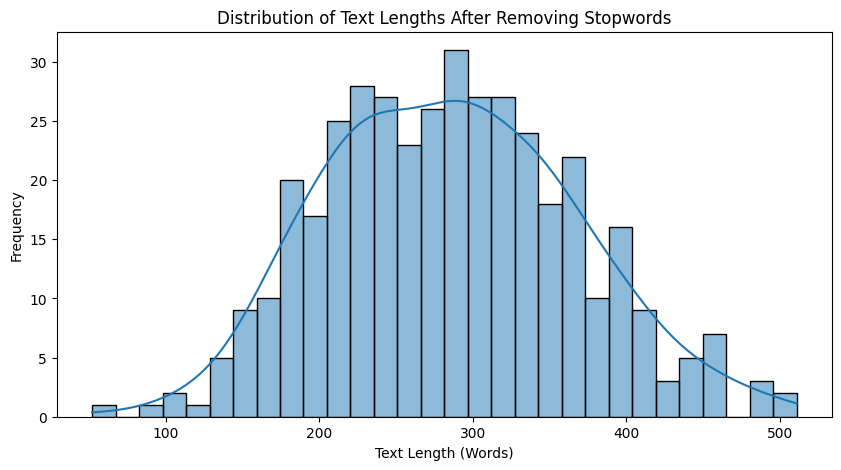

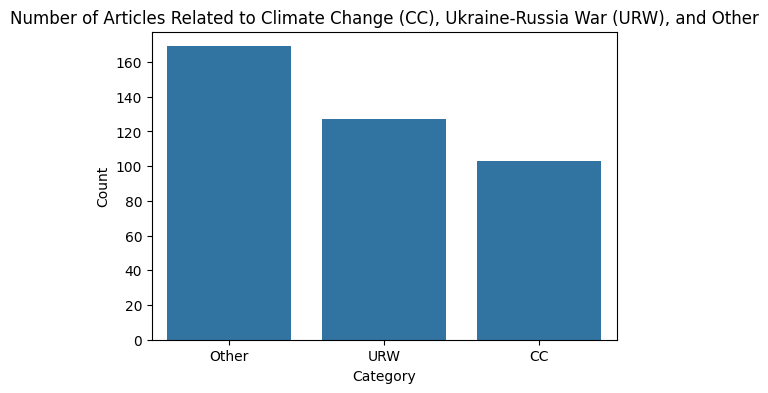

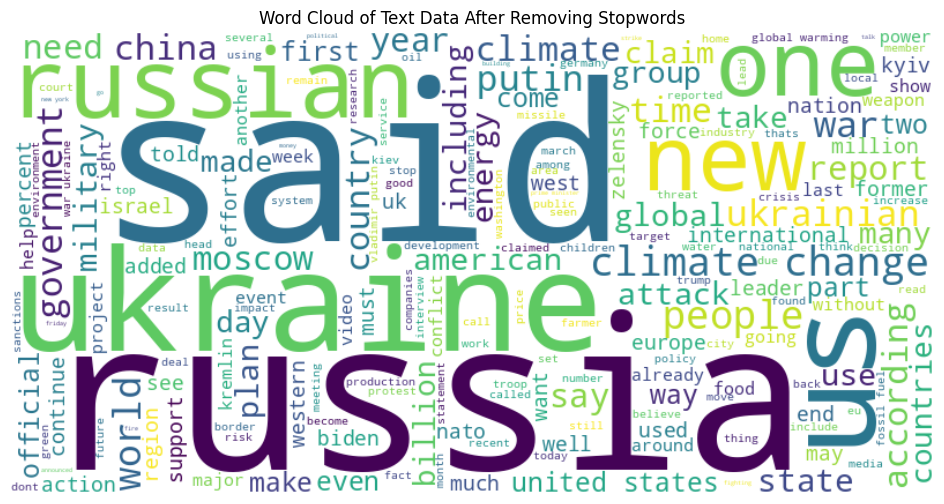

In [6]:
def exploratory_data_analysis(df_annotations, df_texts):
    """Perform EDA on annotation and text data."""
    # Narrative Label Distribution
    narratives = [item for sublist in df_annotations['Narrative Labels'] for item in sublist]
    plt.figure(figsize=(12, 6))
    sns.countplot(y=pd.Series(narratives), order=pd.Series(narratives).value_counts().index)
    plt.xlabel("Count")
    plt.ylabel("Narrative Labels")
    plt.title("Distribution of Narrative Labels")
    plt.show()
    
    # Sub-Narrative Label Distribution (Top 25)
    sub_narratives = [item for sublist in df_annotations['Sub-Narrative Labels'] for item in sublist]
    top_sub_narratives = pd.Series(sub_narratives).value_counts().nlargest(25)
    plt.figure(figsize=(14, 8))
    sns.barplot(y=top_sub_narratives.index, x=top_sub_narratives.values)
    plt.xlabel("Count")
    plt.ylabel("Sub-Narrative Labels")
    plt.title("Top 25 Sub-Narrative Labels")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.show()
    
    # Text Length Distribution
    df_texts['Text Length'] = df_texts['Text Content'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 5))
    sns.histplot(df_texts['Text Length'], bins=30, kde=True)
    plt.xlabel("Text Length (Words)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Text Lengths After Removing Stopwords")
    plt.show()
    
    # Count of Climate Change vs Ukraine-Russia War vs Other Articles
    def categorize_labels(labels):
        if any('CC' in label for label in labels):
            return 'CC'
        elif any('URW' in label for label in labels):
            return 'URW'
        else:
            return 'Other'
    
    df_annotations['Category'] = df_annotations['Narrative Labels'].apply(categorize_labels)
    category_counts = df_annotations['Category'].value_counts()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.title("Number of Articles Related to Climate Change (CC), Ukraine-Russia War (URW), and Other")
    plt.show()
    
    # Generate Word Cloud after Removing Stopwords
    text_corpus = ' '.join(df_texts['Text Content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Text Data After Removing Stopwords")
    plt.show()

# Perform EDA
exploratory_data_analysis(df_annotations, df_texts)

# 2. Training HiMatch Model

## 2.1. Defining Label Hierarchy

In [10]:
import networkx as nx
import torch
import json

def load_label_hierarchy(annotation_file):
    """Load and process the annotation file to extract hierarchical labels."""
    label_hierarchy = {}
    with open(annotation_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                _, narrative, sub_narrative = parts
                narratives = narrative.split(';')  # Split multiple narratives
                sub_narratives = sub_narrative.split(';')  # Split multiple sub-narratives
                
                for narrative, sub_narrative in zip(narratives, sub_narratives):
                    if narrative == "Other":
                        label_hierarchy[narrative] = "Root"  # Keep 'Other' directly under Root
                        label_hierarchy[sub_narrative] = "Other"  # Ensure sub-narrative is also 'Other'
                    else:
                        label_hierarchy[sub_narrative] = narrative
                        label_hierarchy[narrative] = "Root"
    
    return label_hierarchy

def build_label_graph(label_hierarchy):
    """Build a directed graph from the label hierarchy for GCN processing."""
    G = nx.DiGraph()
    for child, parent in label_hierarchy.items():
        G.add_edge(parent, child)
    return G

def prepare_gcn_data(label_hierarchy):
    """Prepare hierarchical label embeddings using GCN."""
    G = build_label_graph(label_hierarchy)
    node_map = {node: i for i, node in enumerate(G.nodes())}
    edges = [(node_map[parent], node_map[child]) for parent, child in G.edges()]
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    num_nodes = len(G.nodes())
    x = torch.eye(num_nodes, dtype=torch.float)  # One-hot encoding for nodes
    
    return x, edge_index, node_map

def save_label_hierarchy(label_hierarchy, output_file):
    """Save the label hierarchy to a JSON file."""
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(label_hierarchy, f, indent=4)

# Example usage
annotation_file = "narrative_classification/training_data/eng/subtask_2_annotations.txt"  # Update with actual file path
label_hierarchy = load_label_hierarchy(annotation_file)

# Save hierarchy
save_label_hierarchy(label_hierarchy, "label_hierarchy.json")

# Prepare GCN data
x, edge_index, node_map = prepare_gcn_data(label_hierarchy)

print("Label hierarchy and GCN data prepared successfully.")

Label hierarchy and GCN data prepared successfully.


## 2.2. Prepare the Trainig Data (BiGRU + CNN)

In [12]:
from collections import Counter
import json

# Load processed data
with open("processed_data.json", "r", encoding="utf-8") as f:
    processed_data = json.load(f)

# Tokenize and count unique words
word_counter = Counter()
for item in processed_data:
    words = item["Text Content"].split()  # Simple tokenization
    word_counter.update(words)

# Print vocabulary size
vocab_size = len(word_counter)
print(f"Total Unique Words in Dataset: {vocab_size}")


Total Unique Words in Dataset: 16961


In [13]:
import torch
import torch.nn as nn
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Load processed data
with open("processed_data.json", "r", encoding="utf-8") as f:
    processed_data = json.load(f)

# Load label hierarchy
with open("label_hierarchy.json", "r", encoding="utf-8") as f:
    label_hierarchy = json.load(f)

# Prepare label encoder
all_labels = list(label_hierarchy.keys())
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Compute Vocabulary Size
word_counter = Counter()
for item in processed_data:
    words = item["Text Content"].split()
    word_counter.update(words)


vocab = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(50000))}  # Limit vocab size to 50,000
vocab["<PAD>"] = 0  # Padding token
vocab["<UNK>"] = len(vocab)  # Unknown token

class HiMatchDataset(Dataset):
    """Custom dataset for HiMatch model training."""
    def __init__(self, data, label_encoder, max_labels=10):  # Define max_labels
        self.data = data
        self.label_encoder = label_encoder
        self.max_labels = max_labels  # Set max labels for padding/truncation
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        text = item["Text Content"]
        labels = item["Narrative Labels"] + item["Sub-Narrative Labels"]
        
        # Encode labels as indices
        label_indices = torch.tensor(self.label_encoder.transform(labels), dtype=torch.long)
        
        # Pad or truncate labels to fixed size
        if len(label_indices) < self.max_labels:
            pad_size = self.max_labels - len(label_indices)
            label_indices = torch.cat([label_indices, torch.full((pad_size,), -1)])  # -1 as padding
        else:
            label_indices = label_indices[:self.max_labels]  # Truncate if too many
        
        return text, label_indices

# Custom collate function to handle padding
def collate_fn(batch):
    texts, labels = zip(*batch)

    # Convert text into numerical tokens
    tokenized_texts = [
        torch.tensor([vocab.get(word, vocab["<UNK>"]) for word in text.split()], dtype=torch.long)
        for text in texts
    ]

    # Pad sequences to the longest in batch
    text_tensor = pad_sequence(tokenized_texts, batch_first=True, padding_value=vocab["<PAD>"])

    # Pad labels
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)

    return text_tensor, labels



# Create dataset and DataLoader
dataset = HiMatchDataset(processed_data, label_encoder)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

class BiGRU_CNN_Encoder(nn.Module):
    """BiGRU + CNN-based text feature extractor with dynamic hyperparameters."""
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, kernel_size=3):
        super(BiGRU_CNN_Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=hidden_dim, kernel_size=kernel_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = x.permute(0, 2, 1)  # Reshape for CNN
        x = self.conv(x)
        x = self.relu(x)
        return torch.mean(x, dim=2)  # Pooling over sequence length

# Example Usage
embed_dim = 128  # Adjust based on dataset size
hidden_dim = 256  # Change based on computational resources
kernel_size = 3  # Use 3 for trigram features

encoder = BiGRU_CNN_Encoder(vocab_size, embed_dim, hidden_dim, kernel_size)
print("Data preparation complete. Ready for model training.")


Data preparation complete. Ready for model training.


In [ ]:
'''
from torch.utils.data import DataLoader

dataset = HiMatchDataset(processed_data, label_encoder)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Get a sample batch
for text, labels in dataloader:
    print("Text Sample:", text)
    print("Encoded Labels:", labels)
    break  # Stop after first batch
    
'''

In [ ]:
'''
from sklearn.preprocessing import LabelEncoder

all_labels = list(label_hierarchy.keys())
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Print label mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

'''

## 2.3. Training the Model

No saved model found. Training from scratch.
Epoch [1/60], Train Loss: 0.6156, Val Loss: 0.5693
Epoch [2/60], Train Loss: 0.5055, Val Loss: 0.4989
Epoch [3/60], Train Loss: 0.4361, Val Loss: 0.4413
Epoch [4/60], Train Loss: 0.3753, Val Loss: 0.3933
Epoch [5/60], Train Loss: 0.3203, Val Loss: 0.3485
Epoch [6/60], Train Loss: 0.2784, Val Loss: 0.3137
Epoch [7/60], Train Loss: 0.2438, Val Loss: 0.2863
Epoch [8/60], Train Loss: 0.2199, Val Loss: 0.2654
Epoch [9/60], Train Loss: 0.2162, Val Loss: 0.2539
Epoch [10/60], Train Loss: 0.2007, Val Loss: 0.2414
Epoch [11/60], Train Loss: 0.1895, Val Loss: 0.2330
Epoch [12/60], Train Loss: 0.1876, Val Loss: 0.2270
Epoch [13/60], Train Loss: 0.1757, Val Loss: 0.2234
Epoch [14/60], Train Loss: 0.1776, Val Loss: 0.2188
Epoch [15/60], Train Loss: 0.1670, Val Loss: 0.2113
Epoch [16/60], Train Loss: 0.1750, Val Loss: 0.2054
Epoch [17/60], Train Loss: 0.1633, Val Loss: 0.2104
Epoch [18/60], Train Loss: 0.1612, Val Loss: 0.2055
Epoch [19/60], Train Loss: 0

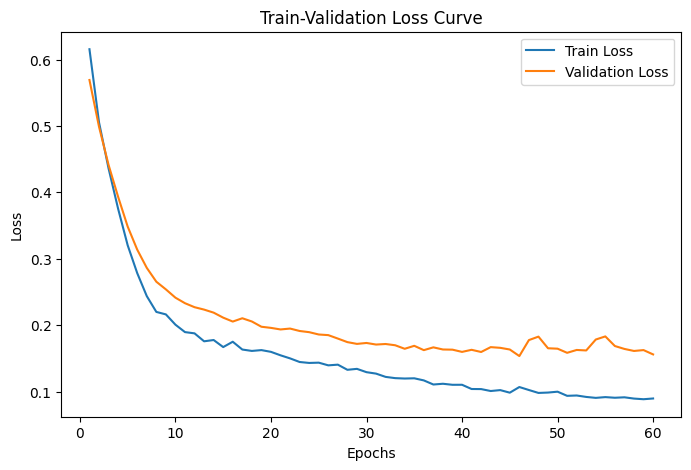

Training complete.
Model saved as himatch_model.pth


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

# Load label embeddings from GCN
x, edge_index, node_map = prepare_gcn_data(label_hierarchy)

class HiMatch(nn.Module):
    """HiMatch Model: Combines BiGRU + CNN (Text) and GCN (Labels)."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, kernel_size, label_embedding_dim):
        super(HiMatch, self).__init__()
        self.text_encoder = BiGRU_CNN_Encoder(vocab_size, embed_dim, hidden_dim, kernel_size)
        self.label_embeddings = nn.Parameter(torch.randn(len(node_map), label_embedding_dim))
        self.projection = nn.Linear(hidden_dim, label_embedding_dim)
    
    def forward(self, text_features):
        text_emb = self.projection(self.text_encoder(text_features))  # Project text features
        label_emb = self.label_embeddings  # Use learned label embeddings
        similarity = torch.matmul(text_emb, label_emb.T)  # Cosine similarity
        return similarity

# Define model
label_embedding_dim = 64
himatch_model = HiMatch(vocab_size, embed_dim, hidden_dim, kernel_size, label_embedding_dim)

# Define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(himatch_model.parameters(), lr=1e-4)

# Split dataset into train and validation
train_size = int(0.9 * len(dataset))
val_size = max(len(dataset) - train_size, 1)  # Ensure at least 1 sample for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

def train_model(num_epochs=60, start_epoch=0):
    """Train the HiMatch model and plot train-validation loss curve."""
    himatch_model.train()
    # Load previously saved model if it exists
    try:
        himatch_model.load_state_dict(torch.load("himatch_model.pth"))
        print("Loaded saved model: himatch_model.pth")
    except FileNotFoundError:
        print("No saved model found. Training from scratch.")
        
    train_losses, val_losses = [], []
    for epoch in range(start_epoch, start_epoch + num_epochs):
        total_train_loss, total_val_loss = 0, 0
        
        # Training loop
        for text_batch, label_batch in train_loader:
            optimizer.zero_grad()

            # Convert label_batch to one-hot encoding
            label_one_hot = torch.zeros((label_batch.size(0), len(node_map)))  # [batch_size, num_labels]
            for i, labels in enumerate(label_batch):
                valid_labels = labels[labels != -1]  # Ignore padding values (-1)
                label_one_hot[i, valid_labels] = 1  # Set corresponding labels to 1
        
            outputs = himatch_model(text_batch)
            loss = criterion(outputs, label_one_hot)  # Use one-hot labels for BCEWithLogitsLoss
        
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Validation loop
        himatch_model.eval()
        with torch.no_grad():
            for text_batch, label_batch in val_loader:
                label_one_hot = torch.zeros((label_batch.size(0), len(node_map)))
                for i, labels in enumerate(label_batch):
                    valid_labels = labels[labels != -1]  
                    label_one_hot[i, valid_labels] = 1  
        
                outputs = himatch_model(text_batch)
                loss = criterion(outputs, label_one_hot)  
                total_val_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Plot train-validation loss curve
    plt.figure(figsize=(8,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train-Validation Loss Curve')
    plt.show()
    
    print("Training complete.")
    torch.save(himatch_model.state_dict(), "himatch_model.pth")
    print("Model saved as himatch_model.pth")

# Train the model
train_model()

## 2.4. Checking if the Model atleast learnt Something !!

In [237]:
print(f"Embedding Layer Size: {himatch_model.text_encoder.embedding.num_embeddings}")
print(f"Vocab Size: {len(vocab)}")


Embedding Layer Size: 16961
Vocab Size: 16963


### 2.4.2. Sample Prediction

In [56]:
class HiMatch(nn.Module):
    """HiMatch Model: Combines BiGRU + CNN (Text) and GCN (Labels)."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, kernel_size, label_embedding_dim):
        super(HiMatch, self).__init__()
        self.text_encoder = BiGRU_CNN_Encoder(vocab_size, embed_dim, hidden_dim, kernel_size)
        self.label_embeddings = nn.Parameter(torch.randn(len(node_map), label_embedding_dim))
        self.projection = nn.Linear(hidden_dim, label_embedding_dim)
    
    def forward(self, text_features):
        text_emb = self.projection(self.text_encoder(text_features))  # Project text features
        label_emb = self.label_embeddings  # Use learned label embeddings
        similarity = torch.matmul(text_emb, label_emb.T)  # Cosine similarity
        return similarity

# Define model
label_embedding_dim = 64
himatch_model = HiMatch(vocab_size, embed_dim, hidden_dim, kernel_size, label_embedding_dim)



himatch_model.load_state_dict(torch.load("himatch_model.pth"))

<All keys matched successfully>

In [68]:
def predict(text):
    himatch_model.eval()

    # Convert words to indices and ensure they stay within range
    tokenized_text = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    tokenized_text = [min(idx, himatch_model.text_encoder.embedding.num_embeddings - 1) for idx in tokenized_text]
    tokenized_text = torch.tensor(tokenized_text, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        outputs = himatch_model(tokenized_text)

    # Apply temperature scaling
    temperature = 0.3 # Lower temperature for better confidence adjustment
    predicted_probs = torch.sigmoid(outputs / temperature).squeeze().cpu().numpy()

    # Adjust thresholds for small dataset
    narrative_threshold = 0.3 # Lower threshold to capture more narratives
    sub_narrative_threshold = 0.15  # Lower threshold for sub-narratives

    predicted_labels = [label for label, idx in node_map.items() if predicted_probs[idx] > narrative_threshold]

    # **Ensure Hierarchical Consistency**
    final_labels = set(predicted_labels)  # Start with predicted labels

    # Organize labels into levels
    narrative_labels = set()
    sub_narrative_labels = set()

    for label in predicted_labels:
        if label in label_hierarchy:
            parent = label_hierarchy[label]
            
            # If the label is a Narrative-Level (has root as parent)
            if parent == "Root":
                narrative_labels.add(label)
            # If the label is a Sub-Narrative-Level (has a narrative as parent)
            elif parent in narrative_labels and predicted_probs[node_map[label]] > sub_narrative_threshold:
                sub_narrative_labels.add(label)
                final_labels.add(parent)  # Ensure parent is included
    
    # Print predictions in separate lines
    print("Narrative-Level Predictions:")
    for label in narrative_labels:
        print(f"  - {label}")
    
    print("Sub-Narrative-Level Predictions:")
    for label in sub_narrative_labels:
        print(f"  - {label}")
    
    # Organize predictions
    hierarchical_predictions = {
        "Narrative-Level": list(narrative_labels),
        "Sub-Narrative-Level": list(sub_narrative_labels),
    }
    
    return hierarchical_predictions

In [69]:
# Example usage
text_sample = "russia launched a full-scale invasion of ukraine and began occupying more of the country"
predictions = predict(text_sample)

Narrative-Level Predictions:
  - CC: Criticism of climate policies
  - CC: Hidden plots by secret schemes of powerful groups
Sub-Narrative-Level Predictions:
  - CC: Hidden plots by secret schemes of powerful groups: Blaming global elites
  - CC: Criticism of climate policies: Climate policies have negative impact on the economy
  - CC: Criticism of climate policies: Other
  - CC: Hidden plots by secret schemes of powerful groups: Climate agenda has hidden motives


# 3. Predict Labels for Test Files (Uannotated)

In [70]:
def predict(text):
    himatch_model.eval()

    # Convert words to indices and ensure they stay within range
    tokenized_text = [vocab.get(word, vocab["<UNK>"]) for word in text.split()]
    tokenized_text = [min(idx, himatch_model.text_encoder.embedding.num_embeddings - 1) for idx in tokenized_text]
    tokenized_text = torch.tensor(tokenized_text, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        outputs = himatch_model(tokenized_text)

    # Apply temperature scaling
    temperature = 0.4  # Lower temperature for better confidence adjustment
    predicted_probs = torch.sigmoid(outputs / temperature).squeeze().cpu().numpy()

    # Adjust thresholds
    narrative_threshold = 0.4
    sub_narrative_threshold = 0.2

    predicted_labels = [label for label, idx in node_map.items() if predicted_probs[idx] > narrative_threshold]

    # Organize labels into hierarchical levels
    narrative_labels = set()
    sub_narrative_labels = set()

    for label in predicted_labels:
        if label in label_hierarchy:
            parent = label_hierarchy[label]
            if parent == "Root":
                narrative_labels.add(label)
            elif parent in narrative_labels and predicted_probs[node_map[label]] > sub_narrative_threshold:
                sub_narrative_labels.add(label)
                narrative_labels.add(parent)  # Ensure parent exists

    return {
        "Narrative-Level": list(narrative_labels),
        "Sub-Narrative-Level": list(sub_narrative_labels),
    }, predicted_probs

In [72]:
import os
import torch

def chunk_text(text, chunk_size=100, overlap=40):
    """Splits text into overlapping chunks for better model predictions."""
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        chunks.append(" ".join(words[start:start + chunk_size]))
        start += chunk_size - overlap  # Create overlapping chunks
    return chunks

def process_all_files(input_dir, output_file):
    """Processes all text files in a directory and writes predictions to an annotation file."""
    
    with open(output_file, "w") as out_f:
        for filename in os.listdir(input_dir):
            if filename.endswith(".txt"):  # Ensure only text files are processed
                file_path = os.path.join(input_dir, filename)
                
                # Read file content
                with open(file_path, "r", encoding="utf-8") as f:
                    raw_text = f.read().strip()
                
                # Apply all preprocessing steps to text
                text = preprocess_text(raw_text)
                
                # Split long text into smaller chunks
                text_chunks = chunk_text(text)
                
                # Store cumulative predictions
                cumulative_narratives = set()
                cumulative_sub_narratives = set()
                
                for chunk in text_chunks:
                    predictions, predicted_probs = predict(chunk)
                    
                    # Adjust thresholding strategy
                    narrative_threshold = 0.3
                    sub_narrative_threshold = 0.15
                    
                    narrative_labels = {label for label in predictions.get("Narrative-Level", []) if predicted_probs[node_map[label]] > narrative_threshold}
                    sub_narrative_labels = {label for label in predictions.get("Sub-Narrative-Level", []) if predicted_probs[node_map[label]] > sub_narrative_threshold}
                    
                    # If no predictions meet threshold, assign highest-probability label instead of "Other"
                    if not narrative_labels:
                        max_prob_label = max(node_map.keys(), key=lambda l: predicted_probs[node_map[l]])
                        narrative_labels.add(max_prob_label)
                    
                    # Ensure sub-narratives belong to selected narratives
                    sub_narrative_labels = {label for label in sub_narrative_labels if any(label.startswith(n) for n in narrative_labels)}
                    
                    # Accumulate labels across chunks
                    cumulative_narratives.update(narrative_labels)
                    cumulative_sub_narratives.update(sub_narrative_labels)
                
                # Adjust label selection strategy
                final_narrative_labels = ";".join(cumulative_narratives) if cumulative_narratives else "Other"
                final_sub_narrative_labels = ";".join(cumulative_sub_narratives) if cumulative_sub_narratives else "Other"
                
                # Write to output file in required format
                out_f.write(f"{filename}\t{final_narrative_labels}\t{final_sub_narrative_labels}\n")
    
    print(f"Predictions saved to {output_file}")

# Example usage
input_directory = "narrative_classification/test_data/eng"  # Change this to the actual directory
output_annotation_file = "subtasked_2_annotation_new.txt"
process_all_files(input_directory, output_annotation_file)

Predictions saved to subtasked_2_annotation_new.txt


# 4. Evaluate Predictions (Gold Label)

In [73]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

def load_annotations(file_path):
    """Loads annotations from a text file into a DataFrame."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                file_id, narratives, sub_narratives = parts
                data.append((file_id, narratives.split(';'), sub_narratives.split(';')))
    return pd.DataFrame(data, columns=['File', 'Narratives', 'Sub-Narratives'])

# Load ground truth and predicted annotations
ground_truth_file = "narrative_classification/gold_label/eng/subtask-2-annotations.txt"
predictions_file = "subtasked_2_annotation_new.txt"
gt_df = load_annotations(ground_truth_file)
pred_df = load_annotations(predictions_file)

# Merge data on File ID
merged_df = gt_df.merge(pred_df, on='File', suffixes=('_true', '_pred'))

def compute_metrics(true_labels, pred_labels):
    """Computes precision, recall, and F1-score for multi-label classification."""
    all_labels = list(set(label for labels in true_labels for label in labels))
    y_true = [[1 if label in labels else 0 for label in all_labels] for labels in true_labels]
    y_pred = [[1 if label in labels else 0 for label in all_labels] for labels in pred_labels]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return precision, recall, f1

# Compute metrics for Narratives
narrative_precision, narrative_recall, narrative_f1 = compute_metrics(merged_df['Narratives_true'], merged_df['Narratives_pred'])
sub_precision, sub_recall, sub_f1 = compute_metrics(merged_df['Sub-Narratives_true'], merged_df['Sub-Narratives_pred'])

# Print Evaluation Results
print("\nModel Evaluation Results:")
print(f"Narrative-Level Precision: {narrative_precision:.4f}, Recall: {narrative_recall:.4f}, F1-score: {narrative_f1:.4f}")
print(f"Sub-Narrative-Level Precision: {sub_precision:.4f}, Recall: {sub_recall:.4f}, F1-score: {sub_f1:.4f}")


Model Evaluation Results:
Narrative-Level Precision: 0.0623, Recall: 0.1610, F1-score: 0.0667
Sub-Narrative-Level Precision: 0.0780, Recall: 0.1383, F1-score: 0.0694


In [3]:
import torch
import json
import pandas as pd
from sklearn.metrics import classification_report

# Load predicted labels
predictions_file = "subtasked_2_annotation_new.txt"
predictions = {}

with open(predictions_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            file_name, pred_labels, pred_sub_labels = parts
            predictions[file_name] = {
                "narratives": set(pred_labels.split(";")),
                "sub_narratives": set(pred_sub_labels.split(";"))
            }

# Load gold labels
gold_labels_file = "narrative_classification/gold_label/eng/subtask-2-annotations.txt"
gold_labels = {}

with open(gold_labels_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            file_name, true_labels, true_sub_labels = parts
            gold_labels[file_name] = {
                "narratives": set(true_labels.split(";")),
                "sub_narratives": set(true_sub_labels.split(";"))
            }

# Convert to multi-label binary format
all_labels = sorted(set(label for data in gold_labels.values() for label in data["narratives"]))
all_sub_labels = sorted(set(label for data in gold_labels.values() for label in data["sub_narratives"]))

label_index = {label: i for i, label in enumerate(all_labels)}
sub_label_index = {label: i for i, label in enumerate(all_sub_labels)}

def convert_to_binary_vectors(data, label_index):
    binary_vectors = []
    for file, values in data.items():
        vector = [0] * len(label_index)
        for label in values:
            if label in label_index:
                vector[label_index[label]] = 1
        binary_vectors.append(vector)
    return binary_vectors

y_true = convert_to_binary_vectors({k: v["narratives"] for k, v in gold_labels.items()}, label_index)
y_pred = convert_to_binary_vectors({k: v["narratives"] for k, v in predictions.items()}, label_index)

y_true_sub = convert_to_binary_vectors({k: v["sub_narratives"] for k, v in gold_labels.items()}, sub_label_index)
y_pred_sub = convert_to_binary_vectors({k: v["sub_narratives"] for k, v in predictions.items()}, sub_label_index)

# Evaluate narratives
print("Narrative Classification Report:")
print(classification_report(y_true, y_pred, target_names=all_labels, zero_division=0))

# Evaluate sub-narratives
print("\nSub-Narrative Classification Report:")
print(classification_report(y_true_sub, y_pred_sub, target_names=all_sub_labels, zero_division=0))

Narrative Classification Report:
                                                        precision    recall  f1-score   support

                      CC: Climate change is beneficial       0.00      0.00      0.00         1
              CC: Controversy about green technologies       0.00      0.00      0.00         2
                     CC: Criticism of climate movement       0.00      0.00      0.00         8
                     CC: Criticism of climate policies       0.03      0.33      0.06         3
         CC: Criticism of institutions and authorities       0.00      0.00      0.00         8
                        CC: Downplaying climate change       0.00      0.00      0.00         2
       CC: Green policies are geopolitical instruments       0.00      0.00      0.00         3
 CC: Hidden plots by secret schemes of powerful groups       0.09      0.50      0.15         4
          CC: Questioning the measurements and science       0.33      0.50      0.40         4
      